# 科目が同じ品種をグループにして分類器を作る（生育済み）
雑草の生育期間が生育済みのデータを用いて分類器を作成します。 ハキダメギク、ホソアオゲイトウ、イチビ、イヌビエ、コセンダングサ、マメアサガオ、メヒシバ、オヒシバ、オイヌタデ、シロザの10種類の雑草のうち科目が同じのものを一つのclassにまとめるます。イネ科（イヌビエ、メヒシバ、オヒシバ）、キク科（ハキダメギク、コセンダングサ）とその他5種類に分けて分類器を作成します。

### ■データのダウンロード

・cluster.zipをダウンロードします。

In [0]:
#グーグルドライブからファイルをダウンロードする方法
#ファイル限定

import requests

def download_file_from_google_drive(id, destination):

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)

    token = get_confirm_token(response)

    if token:

        params = { 'id' : id, 'confirm' : token }

        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):

    for key, value in response.cookies.items():

        if key.startswith('download_warning'):

            return value

    return None

def save_response_content(response, destination):

    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:

        for chunk in response.iter_content(CHUNK_SIZE):

            if chunk: # filter out keep-alive new chunks

                f.write(chunk)

#取得されるトークン
file_id = '1lPfeXGOpo5Uvi8zf2x0KIyYYXGQLE4F2'

#欲しいフォルダ名
destination = 'cluster.zip'

download_file_from_google_drive(file_id, destination)



・cluster.zipを解凍します。

In [0]:
!unzip cluster
print("clusterファイルの解凍が完了しました。")

### ■データセットの作成

・データセットの画像を表示します（イネ科、キク科、その他）

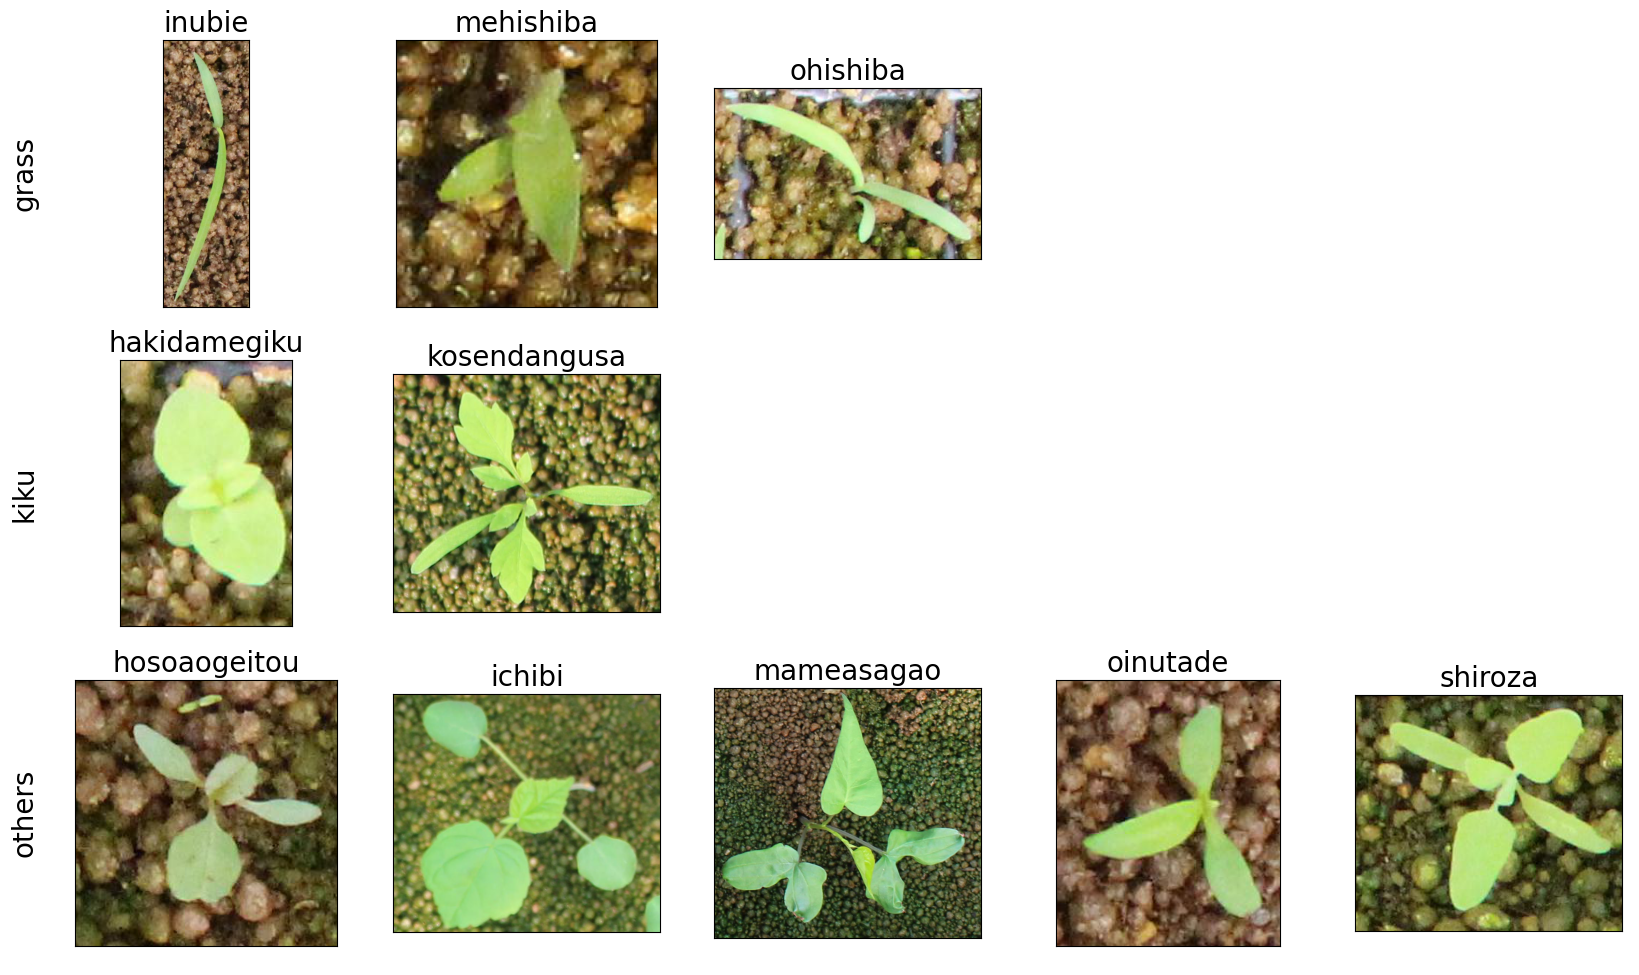

In [3]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

def show_weed():
  #　雑草名と生育状態をリストに定義
  weed_names = ["hakidamegiku","hosoaogeitou","ichibi","inubie","kosendangusa","mameasagao","mehishiba","ohishiba","oinutade","shiroza"]
  weed_categoly = {"hakidamegiku":"kiku","hosoaogeitou":"hosoaogeitou","ichibi":"ichibi",
         "inubie":"grass","kosendangusa":"kiku","mameasagao":"mameasagao",
         "mehishiba":"grass","ohishiba":"grass","oinutade":"oinutade","shiroza":"shiroza"}
  weed_type = ["sprout", "grown"]

  #　データ格納フォルダを指定
  input_dir = "./cluster"

  #　リストの長さを足して表示枚数を確認
  hs = 15

  #　表示設定
  col= 5
  row=hs/col
  cols=col*4
  rows=row*4
  dpis = 100

  #　イメージの表示サイズ、解像度
  fig = plt.figure(figsize=(cols,rows),dpi=dpis)
  
  #　＊＊番目に指定
  pi1=1
  pi2=6
  pi3=11

  #　grassイメージ表示
  for weed_name in weed_names:
    if weed_categoly[weed_name] == "grass":
      img_path = os.path.join(input_dir, weed_name, weed_type[1])
      img_list = os.listdir(img_path)
      plot_num = pi1
      ax=fig.add_subplot(row, col, plot_num)
      ax.set_title(weed_name, fontsize=20)
      if plot_num == 1:
        plt.ylabel("grass", fontsize=20) # y軸ラベル
      img = Image.open(os.path.join(img_path, img_list[2]))
      plt.xticks(color="None")
      plt.yticks(color="None")
      plt.tick_params(length=0)
      plt.imshow(img, cmap='gray')
      pi1 = pi1+1
    elif weed_categoly[weed_name] == "kiku":
      img_path = os.path.join(input_dir, weed_name, weed_type[1])
      img_list = os.listdir(img_path)
      plot_num = pi2
      ax=fig.add_subplot(row, col, plot_num)
      ax.set_title(weed_name, fontsize=20)
      if plot_num == 6:
        plt.ylabel("kiku", fontsize=20) # y軸ラベル
      img = Image.open(os.path.join(img_path, img_list[2]))
      plt.xticks(color="None")
      plt.yticks(color="None")
      plt.tick_params(length=0)
      plt.imshow(img, cmap='gray')
      pi2 = pi2+1
    else:
      img_path = os.path.join(input_dir, weed_name, weed_type[1])
      img_list = os.listdir(img_path)
      plot_num = pi3
      ax=fig.add_subplot(row, col, plot_num)
      ax.set_title(weed_name, fontsize=20)
      if plot_num == 11:
        plt.ylabel("others", fontsize=20) # y軸ラベル
      img = Image.open(os.path.join(img_path, img_list[2]))
      plt.xticks(color="None")
      plt.yticks(color="None")
      plt.tick_params(length=0)
      plt.imshow(img, cmap='gray')
      pi3 = pi3+1

  fig.align_labels()

show_weed()

・train、validation、prediction用のディレクトリを作成し、class用のディレクトリを追加します

In [4]:
import os, shutil

# The directory where we will
# store our smaller dataset
base_dir = "./CLS"
if "CLS" not in os.listdir("./"):
  os.mkdir(base_dir)
else:
  print(base_dir, "は既に存在します")

train_index = "train"
train_dir = os.path.join(base_dir, train_index)
if train_index not in os.listdir(base_dir):
  os.mkdir(train_dir)
else:
  print(train_dir + "は既に存在します")

validation_index = "validation"
validation_dir = os.path.join(base_dir, validation_index)
if validation_index not in os.listdir(base_dir):
  os.mkdir(validation_dir)
else:
  print(validation_dir + "は既に存在します")

prediction_index = "prediction"
prediction_dir = os.path.join(base_dir, prediction_index)
if prediction_index not in os.listdir(base_dir):
  os.mkdir(prediction_dir)
else:
  print(prediction_dir + "は既に存在します")

#7分類のclassを入力
classes=["kiku","hosoaogeitou","ichibi",
         "grass","mameasagao",
         "oinutade","shiroza",]
dirs = os.listdir(base_dir)
for dir in dirs:
  for cls in classes:
    # Directory with our training pictures
    class_dir = os.path.join(base_dir, dir, cls)
    if cls not in os.listdir(base_dir + "/" + dir):
      os.mkdir(class_dir)
    else:
      print(class_dir, "は既に存在します")

print("作成完了！")

作成完了！


・画像をディレクトリに振り分けます

In [0]:
from os.path import join
import random

# クラス作成用の品種の名前を定義
classes = {"hakidamegiku":"kiku","hosoaogeitou":"hosoaogeitou","ichibi":"ichibi",
         "inubie":"grass","kosendangusa":"kiku","mameasagao":"mameasagao",
         "mehishiba":"grass","ohishiba":"grass","oinutade":"oinutade","shiroza":"shiroza"}

clsdir = "./cluster"
base_dir = "./CLS"
# weed_typeを生育済みのみに設定
weed_types = ["grown"]
weed_names = os.listdir(clsdir)
# ファイル（クラスごとに分かれている）を順番に読み取り
# train, validationデータを作成
for tra_val_dir in ["train", "validation"]:
  for weed_name in weed_names:
    for weed_type in weed_types:
      # grass(イネ科)    
      if classes[weed_name] == "grass": 
        print(weed_name)
        file_names = os.listdir(os.path.join(clsdir, weed_name, weed_type))
        files30 = random.sample(file_names, int(14))
        for file_name in file_names:
          if  file_name in files30:
            # 移動元のファイル
            path1 = os.path.join(clsdir, weed_name, weed_type, file_name)
            # 移動先のファイル
            path2= os.path.join(base_dir, tra_val_dir, classes[weed_name], file_name)
            # ファイルを移動
            new_path = shutil.move(path1, path2)
            # ファイルの存在確認
            print(os.path.exists(path2))
      # kiku(キク科)    
      elif classes[weed_name] == "kiku": 
        print(weed_name)
        file_names = os.listdir(os.path.join(clsdir, weed_name, weed_type))
        files45 = random.sample(file_names, int(21))
        for file_name in file_names:
          if  file_name in files45:
            # 移動元のファイル
            path1 = os.path.join(clsdir, weed_name, weed_type, file_name)
            # 移動先のファイル
            path2= os.path.join(base_dir, tra_val_dir, classes[weed_name], file_name)
            # ファイルを移動
            new_path = shutil.move(path1, path2)
            # ファイルの存在確認
            print(os.path.exists(path2))
      # それ以外   
      else: 
        print(weed_name)
        file_names = os.listdir(os.path.join(clsdir, weed_name, weed_type))
        files90 = random.sample(file_names, int(42))
        for file_name in file_names:
          if  file_name in files90:
            # 移動元のファイル
            path1 = os.path.join(clsdir, weed_name, weed_type, file_name)
            # 移動先のファイル
            path2= os.path.join(base_dir, tra_val_dir, classes[weed_name], file_name)
            # ファイルを移動
            new_path = shutil.move(path1, path2)
            # ファイルの存在確認
            print(os.path.exists(path2))

# predictionデータを作成
for tra_val_dir in ["prediction"]:
  for weed_name in weed_names:
    for weed_type in weed_types:
      # grass(イネ科)    
      if classes[weed_name] == "grass": 
        print(weed_name)
        file_names = os.listdir(os.path.join(clsdir, weed_name, weed_type))
        files06 = random.sample(file_names, int(4))
        for file_name in file_names:
          if  file_name in files06:
            # 移動元のファイル
            path1 = os.path.join(clsdir, weed_name, weed_type, file_name)
            # 移動先のファイル
            path2= os.path.join(base_dir, tra_val_dir, classes[weed_name], file_name)
            # ファイルを移動
            new_path = shutil.move(path1, path2)
            # ファイルの存在確認
            print(os.path.exists(path2))
      # kiku(キク科)    
      elif classes[weed_name] == "kiku": 
        print(weed_name)
        file_names = os.listdir(os.path.join(clsdir, weed_name, weed_type))
        files09 = random.sample(file_names, int(6))
        for file_name in file_names:
          if  file_name in files09:
            # 移動元のファイル
            path1 = os.path.join(clsdir, weed_name, weed_type, file_name)
            # 移動先のファイル
            path2= os.path.join(base_dir, tra_val_dir, classes[weed_name], file_name)
            # ファイルを移動
            new_path = shutil.move(path1, path2)
            # ファイルの存在確認
            print(os.path.exists(path2))
      # それ以外   
      else: 
        print(weed_name)
        file_names = os.listdir(os.path.join(clsdir, weed_name, weed_type))
        files18 = random.sample(file_names, int(12))
        for file_name in file_names:
          if  file_name in files18:
            # 移動元のファイル
            path1 = os.path.join(clsdir, weed_name, weed_type, file_name)
            # 移動先のファイル
            path2= os.path.join(base_dir, tra_val_dir, classes[weed_name], file_name)
            # ファイルを移動
            new_path = shutil.move(path1, path2)
            # ファイルの存在確認
            print(os.path.exists(path2))


・trainデータ、validationデータ、predictionデータのgeneratorを作成します

In [9]:
import os 
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import keras.preprocessing.image as Image

input_size = 224

train_dir = "./CLS/train"
validation_dir = "./CLS/validation"


train_datagen = Image.ImageDataGenerator(
            featurewise_center = False,
            samplewise_center = False,
            featurewise_std_normalization = False,
            samplewise_std_normalization = False,
            zca_whitening = False,
            rotation_range = 90,
            width_shift_range = 0.3,
            height_shift_range = 0.3,
            horizontal_flip = True,
            vertical_flip = False,
            rescale=1./255
        )

val_datagen = Image.ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(input_size,input_size),
            batch_size=7,
            class_mode='categorical'
        )

validation_generator = val_datagen.flow_from_directory(
            validation_dir,
            target_size=(input_size,input_size),
            batch_size=7,
            class_mode='categorical'
        )
print("データセット作成完了！")

Found 294 images belonging to 7 classes.
Found 294 images belonging to 7 classes.
データセット作成完了！


### ■トレーニングの実行

・モデルのレイヤー構成を定義します

In [10]:

#ファインチューニング+VGG+水増し。ここから実行してOK（VGG16をダウンロード）
from keras import models
from keras import layers
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.applications import VGG16
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History, Callback
from keras.objectives import categorical_crossentropy
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.utils import to_categorical
from scipy.stats import mode
import os, pickle


def create_cnn():
  input_size=224
  #input_sizeは224,224までOK。

  vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(input_size,input_size, 3))
  last = vgg_conv.output

  vgg_conv.trainable = True

  set_trainable = False
  for layer in vgg_conv.layers:
    if layer.name == 'block5_conv1':
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False

  mod = Flatten()(last)
  mod = Dense(256, activation='relu')(mod)
  #mod = Dropout(0.5)(mod)
  preds = Dense(7, activation='softmax')(mod)

  model = models.Model(vgg_conv.input, preds)

  return model
print("レイヤー構成を定義しました！")

レイヤー構成を定義しました！


・チェックポイントを定義します(val lossが一番低い値の時にweightファイルを保存)

In [11]:
class Checkpoint(Callback):
    def __init__(self, model, filepath):
        self.model = model
        self.filepath = filepath
        self.best_val_acc = 0.0
        self.best_val_loss = 0.7

    def on_epoch_end(self, epoch, logs):
        # val_lossが最小の時ににweightを保存する
        if self.best_val_loss > logs["val_loss"]:
            self.model.save_weights(self.filepath)
            self.best_val_loss = logs["val_loss"]
            print("Weights saved.", self.best_val_loss)
print("チェックポイントを定義しました！")

チェックポイントを定義しました！


・学習の実行手順を定義します

In [12]:
def train():
    print("学習を開始します")
    hist = History()
    train_model = create_cnn()
    train_model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
    cp = Checkpoint(train_model, f"weights.hdf5")
    train_model.fit_generator(train_generator,epochs=10,validation_data=validation_generator,callbacks=[hist, cp])      
    print("学習が完了しました")
    return hist.history
print("実行手順を定義しました！")

実行手順を定義しました！


・学習を開始します

In [13]:
K.clear_session()
hist = train()

学習を開始します
58892288/58889256 [==============================] - 2s 0us/step
Epoch 1/10
42/42 [==============================] - 12s 294ms/step - loss: 1.8337 - accuracy: 0.2721 - val_loss: 1.6518 - val_accuracy: 0.4524
Epoch 2/10
42/42 [==============================] - 6s 138ms/step - loss: 1.4180 - accuracy: 0.5374 - val_loss: 1.0567 - val_accuracy: 0.5952
Epoch 3/10
42/42 [==============================] - 6s 137ms/step - loss: 1.1201 - accuracy: 0.6156 - val_loss: 0.4890 - val_accuracy: 0.6735
Weights saved. 0.4890100657939911
Epoch 4/10
42/42 [==============================] - 6s 136ms/step - loss: 0.8358 - accuracy: 0.7109 - val_loss: 0.8979 - val_accuracy: 0.8129
Epoch 5/10
42/42 [==============================] - 6s 139ms/step - loss: 0.6387 - accuracy: 0.8027 - val_loss: 0.6058 - val_accuracy: 0.8095
Epoch 6/10
42/42 [==============================] - 6s 140ms/step - loss: 0.5226 - accuracy: 0.8299 - val_loss: 0.3559 - val_accuracy: 0.8673
Weights saved. 0.3559339642524719
Epoch

### ■正解率と損失率をグラフ化

・trainの正解率と損失率、validationの正解率と損失率をグラフ化します

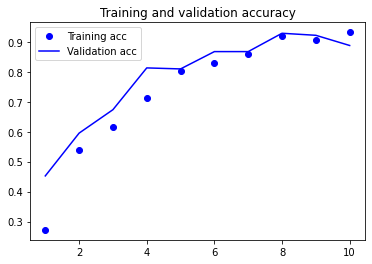

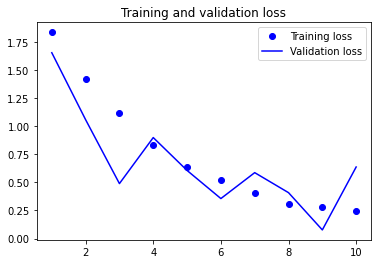

In [14]:
import matplotlib.pyplot as plt

history = hist

acc=history['accuracy']
val_acc=history['val_accuracy']
loss=history['loss']
val_loss=history['val_loss']

epochs=range(1,len(acc)+1)

#正解率plot
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


#損失値をplot
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


### ■テスト

・prediction用のデータセットを作成します

In [31]:
from PIL import Image
import os, glob
import numpy as np
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES =True

prediction_dir = "./CLS/prediction"
prediction_classes = ["grass","hosoaogeitou","ichibi","kiku","mameasagao","oinutade","shiroza"]

image_size = 224
print(prediction_classes)
X_test = []
y_test = []
for index, classlabel in enumerate(prediction_classes):
    photos_dir = os.path.join(prediction_dir, classlabel)
    files = glob.glob(photos_dir + "/*.JPG")
    print(files)
    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        if i == 0:
          print(data.shape)
        X_test.append(data)
        y_test.append(index)

X_test1 = np.array(X_test)
y_test1 = np.array(y_test)
print("predictionデータ作成完了！")

['grass', 'hosoaogeitou', 'ichibi', 'kiku', 'mameasagao', 'oinutade', 'shiroza']
['./CLS/prediction/grass/mehishiba_IMG_1581_12.JPG', './CLS/prediction/grass/ohishiba_IMG_1584_11.JPG', './CLS/prediction/grass/ohishiba_IMG_1584_13.JPG', './CLS/prediction/grass/mehishiba_IMG_1726_7.JPG', './CLS/prediction/grass/mehishiba_IMG_1557_2.JPG', './CLS/prediction/grass/ohishiba_IMG_1561_24.JPG', './CLS/prediction/grass/ohishiba_IMG_1559_33.JPG', './CLS/prediction/grass/inubie_IMG_1505_30.JPG', './CLS/prediction/grass/inubie_IMG_1562_7.JPG', './CLS/prediction/grass/inubie_IMG_1516_5.JPG', './CLS/prediction/grass/mehishiba_IMG_1529_36.JPG', './CLS/prediction/grass/inubie_IMG_1502_2.JPG']
(224, 224, 3)
['./CLS/prediction/hosoaogeitou/hosoaogeitou_IMG_1597_18.JPG', './CLS/prediction/hosoaogeitou/hosoaogeitou_IMG_1598_27.JPG', './CLS/prediction/hosoaogeitou/hosoaogeitou_IMG_1598_15.JPG', './CLS/prediction/hosoaogeitou/hosoaogeitou_IMG_1597_26.JPG', './CLS/prediction/hosoaogeitou/hosoaogeitou_IMG_1616

・混合行列表示用の関数を定義します

In [16]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=-90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print("混合行列表示用の関数を定義しました！")

混合行列表示用の関数を定義しました！


・保存したweightファイルをロードしてpredictionを行います


In [17]:
def sin_predict():
    
    X_test, y_test = X_test1, y_test1
    X_test = X_test / 255.0
    y_test_label = np.ravel(y_test)
    y_test = to_categorical(y_test)
  
    train_model = create_cnn()
    train_model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

    # 最良のモデルの読み込み
    train_model.load_weights(f"weights.hdf5")
    for layer in train_model.layers:
        layer.trainable = False

    # 単体のテスト
    single_pred = np.argmax(train_model.predict(X_test), axis=-1)

    # テストのスコア
    test_acc = accuracy_score(y_test, to_categorical(single_pred))

    print("テストの結果は", test_acc, "です")
    
    target_names = ["grass","hosoaogeitou","ichibi","kiku","mameasagao","oinutade","shiroza"]
    cm = confusion_matrix(y_test_label, single_pred)
    plot_confusion_matrix(cm, classes = target_names) 
    # print('Classification Report')
    # print(classification_report(y_test_label, single_preds, target_names=target_names))
print("テスト用の関数を定義しました！")

テスト用の関数を定義しました！


・テストを実行します

テストの結果は 0.9404761904761905 です
Confusion matrix, without normalization


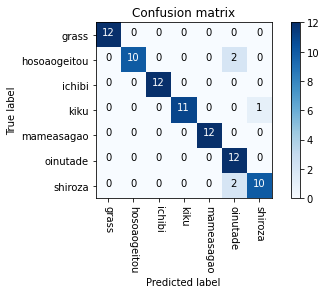

In [32]:
# テスト
sin_predict()

### ■任意の写真をテストします

・画像テスト用の関数を定義します

In [19]:
def result_predict(path):
    prediction_classes = ["grass","hosoaogeitou","ichibi","kiku","mameasagao","oinutade","shiroza"]

    train_model = create_cnn()
    train_model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

    # 最良のモデルの読み込み
    train_model.load_weights(f"weights.hdf5")
    for layer in train_model.layers:
        layer.trainable = False  
    
    X_test = []
    image_size = 224
    image = Image.open(path)
    image = image.convert("RGB")
    image = image.resize((image_size, image_size))
    data = np.asarray(image)
    X_test.append(data)
    X_test = np.array(X_test)
    result = np.argmax(train_model.predict(X_test), axis=-1)
    print("雑草の種類は", prediction_classes[result[0]], "です")
print("画像テスト用の関数を定義しました！")

画像テスト用の関数を定義しました！


・predictionディレクトリから任意の写真を選択しpathを設定します

In [37]:
image_dir = "/content/CLS/prediction/mameasagao/mameasagao_IMG_0004_3.JPG"
result_predict(image_dir)

雑草の種類は mameasagao です
